In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


--- Dataset Overview ---
                              patientId      x      y  width  height  Target  \
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   
5  00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1   
8  00704310-78a8-4b38-8475-49f4573b2dbb  323.0  577.0  160.0   104.0       1   
9  00704310-78a8-4b38-8475-49f4573b2dbb  695.0  575.0  162.0   137.0       1   

          label  age sex modality position  
3        Normal   28   M       CR       PA  
4  Lung Opacity   32   F       CR       AP  
5  Lung Opacity   32   F       CR       AP  
8  Lung Opacity   75   M       CR       PA  
9  Lung Opacity   75   M       CR       PA  

Total Samples: 18406

Class Distribution:
label
Lung Opacity    9555
Normal          8851
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


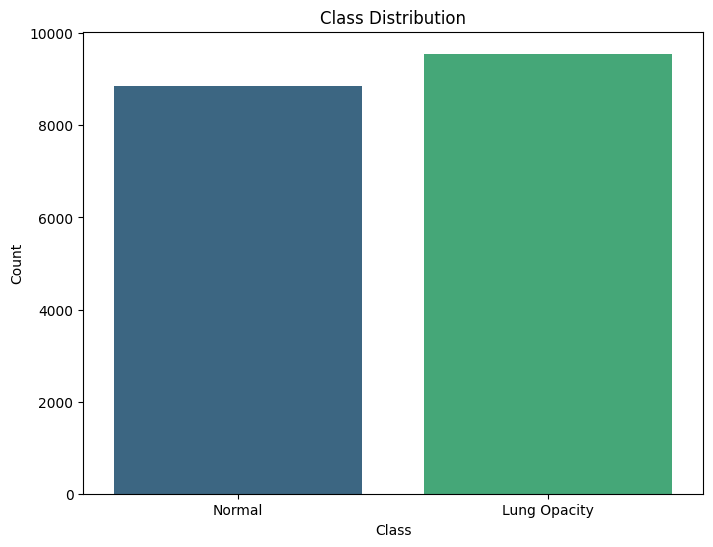

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


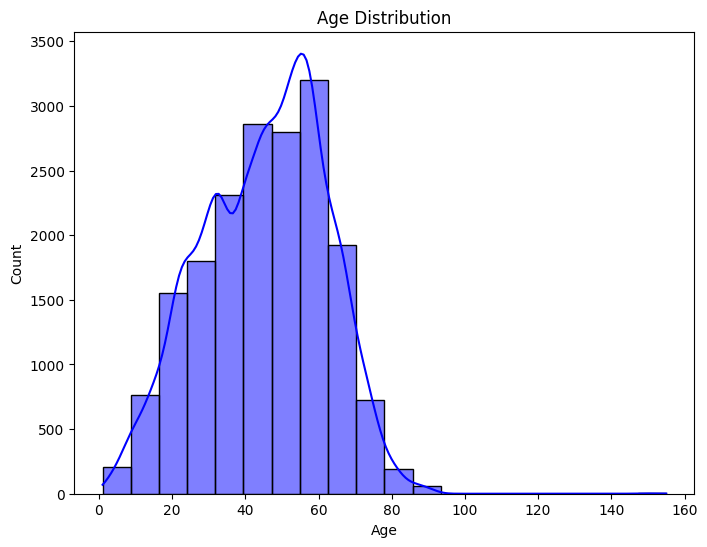

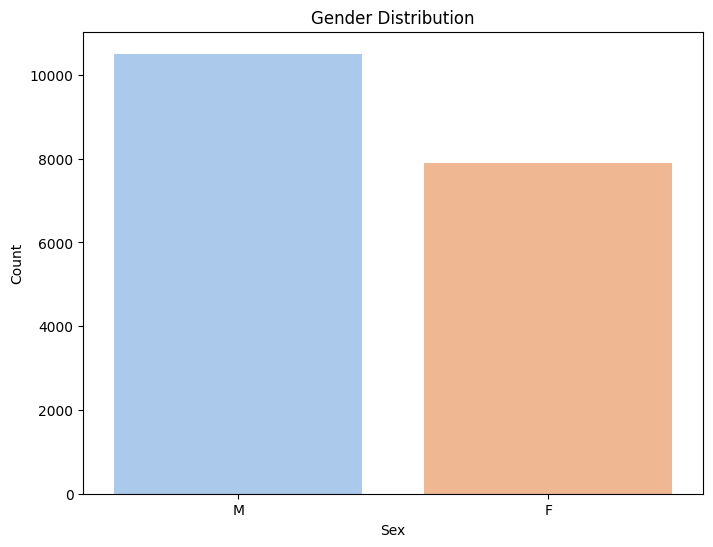

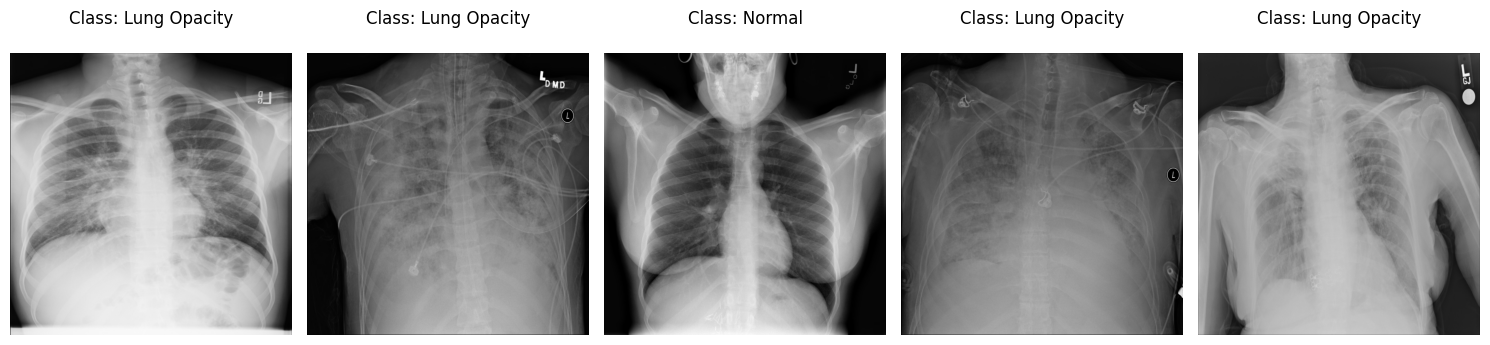

In [10]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Define file paths
images_dir = "/kaggle/input/rsna-pneumonia-processed-dataset/Training/Images"
masks_dir = "/kaggle/input/rsna-pneumonia-processed-dataset/Training/Masks"
train_metadata_path = "/kaggle/input/rsna-pneumonia-processed-dataset/stage2_train_metadata.csv"

# Load metadata
metadata = pd.read_csv(train_metadata_path)

# Rename 'class' column to avoid conflicts with Python reserved keywords
metadata.rename(columns={'class': 'label'}, inplace=True)

# Filter metadata if needed (e.g., selecting specific classes)
metadata = metadata[metadata['label'].isin(['Lung Opacity', 'Normal'])]
metadata['Target'] = metadata['label'].map({'Lung Opacity': 1, 'Normal': 0})

# Exploratory Data Analysis

def eda(metadata, images_dir):
    print("\n--- Dataset Overview ---")
    print(metadata.head())
    print(f"\nTotal Samples: {len(metadata)}")
    print(f"\nClass Distribution:\n{metadata['label'].value_counts()}")

    # Class distribution visualization
    plt.figure(figsize=(8, 6))
    sns.countplot(data=metadata, x='label', palette='viridis')
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

    # Age distribution visualization
    if 'age' in metadata.columns:
        plt.figure(figsize=(8, 6))
        sns.histplot(metadata['age'], kde=True, bins=20, color='blue')
        plt.title('Age Distribution')
        plt.xlabel('Age')
        plt.ylabel('Count')
        plt.show()

    # Gender distribution visualization
    if 'sex' in metadata.columns:
        plt.figure(figsize=(8, 6))
        sns.countplot(data=metadata, x='sex', palette='pastel')
        plt.title('Gender Distribution')
        plt.xlabel('Sex')
        plt.ylabel('Count')
        plt.show()

    # Random sample visualization
    sample = metadata.sample(5)
    plt.figure(figsize=(15, 5))
    for i, row in enumerate(sample.itertuples(index=False)):
        img_path = os.path.join(images_dir, f"{row.patientId}.png")
        image = Image.open(img_path).convert("RGB")
        plt.subplot(1, 5, i + 1)
        plt.imshow(image)
        plt.title(f"Class: {row.label}\n")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Perform EDA
eda(metadata, images_dir)

In [3]:
import os
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from transformers import ViTForImageClassification, ViTFeatureExtractor
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from tqdm import tqdm

# Define file paths
images_dir = "/kaggle/input/rsna-pneumonia-processed-dataset/Training/Images"
masks_dir = "/kaggle/input/rsna-pneumonia-processed-dataset/Training/Masks"
train_metadata_path = "/kaggle/input/rsna-pneumonia-processed-dataset/stage2_train_metadata.csv"

# Load metadata
metadata = pd.read_csv(train_metadata_path)

# Filter metadata if needed (e.g., selecting specific classes)
metadata = metadata[metadata['class'].isin(['Lung Opacity', 'Normal'])]
metadata['Target'] = metadata['class'].map({'Lung Opacity': 1, 'Normal': 0})

# Define custom dataset class
class PneumoniaRSNADataset(Dataset):
    def __init__(self, metadata, images_dir, masks_dir, transform=None, mask_transform=None):
        self.metadata = metadata
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        image_path = os.path.join(self.images_dir, f"{row['patientId']}.png")
        mask_path = os.path.join(self.masks_dir, f"{row['patientId']}.png")
        
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L") if os.path.exists(mask_path) else None

        label = row['Target']
        
        if self.transform:
            image = self.transform(image)
        if mask is not None and self.mask_transform:
            mask = self.mask_transform(mask)

        return image, label, mask

# Define transformations for images and masks
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

mask_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Create dataset and dataloaders
train_dataset = PneumoniaRSNADataset(metadata, images_dir, masks_dir, transform=image_transform, mask_transform=mask_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Load Vision Transformer model
model_name = "google/vit-base-patch16-224"
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=2,  # Binary classification: Normal (0), Pneumonia (1)
    ignore_mismatched_sizes=True
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=5e-5)
criterion = CrossEntropyLoss()

# Training loop
def train_model(model, train_loader, criterion, optimizer, epochs=5):
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for images, labels, masks in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%")

# Train the model
train_model(model, train_loader, criterion, optimizer, epochs=5)

# Save the trained model
model.save_pretrained("/kaggle/working/rsna_pneumonia_detection_vit")


/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 576/576 [18:51<00:00,  1.96s/it]


Epoch 1/5, Loss: 99.5854, Accuracy: 93.42%


100%|██████████| 576/576 [13:28<00:00,  1.40s/it]


Epoch 2/5, Loss: 57.0174, Accuracy: 96.57%


100%|██████████| 576/576 [13:17<00:00,  1.38s/it]


Epoch 3/5, Loss: 34.0410, Accuracy: 97.96%


100%|██████████| 576/576 [13:17<00:00,  1.38s/it]


Epoch 4/5, Loss: 21.6314, Accuracy: 98.79%


100%|██████████| 576/576 [13:12<00:00,  1.38s/it]


Epoch 5/5, Loss: 15.9969, Accuracy: 99.04%


Processing Samples:   0%|          | 0/5 [00:00<?, ?it/s]

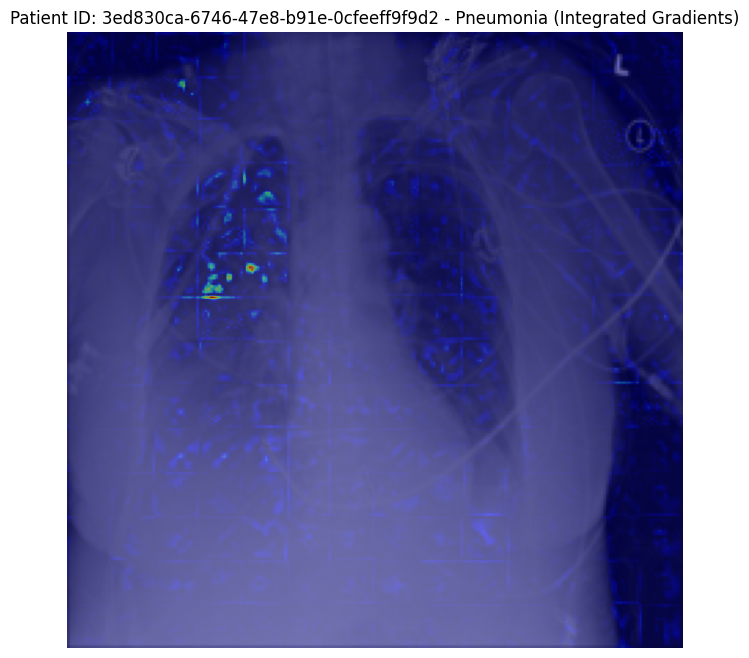

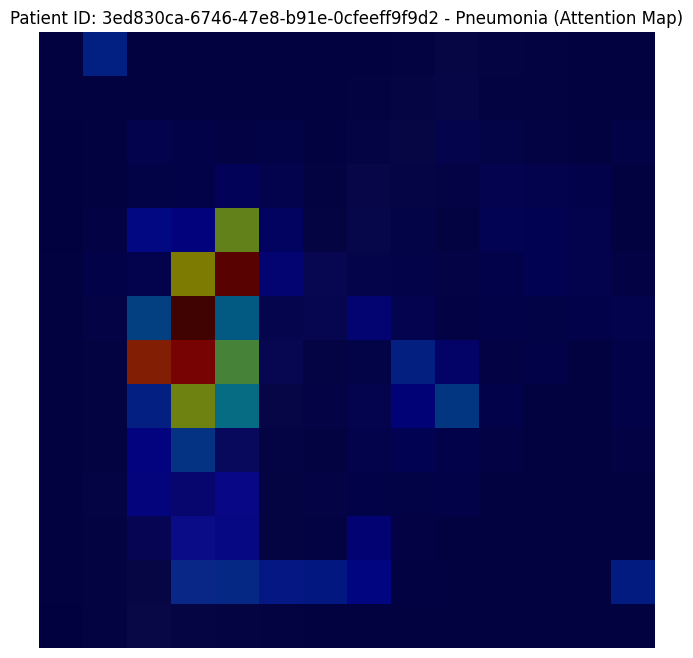

Processing Samples:  20%|██        | 1/5 [00:01<00:06,  1.71s/it]

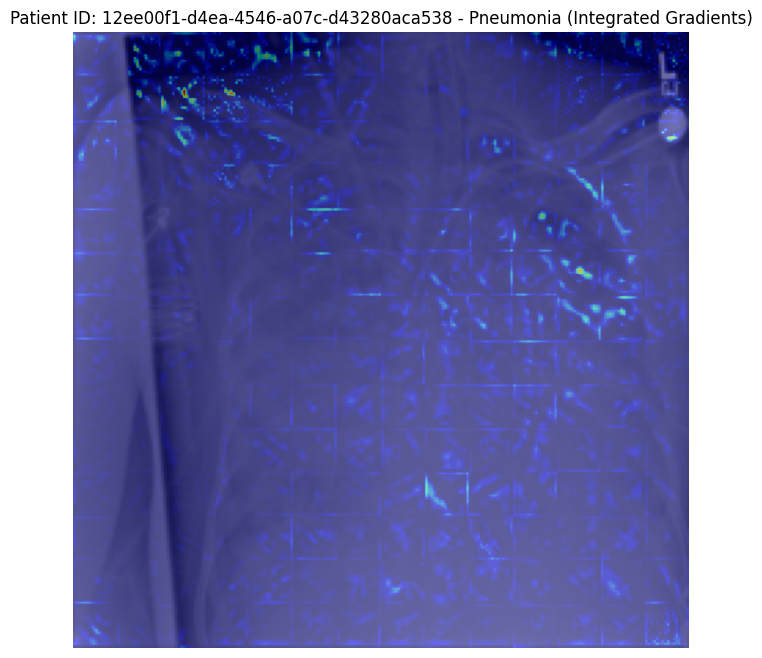

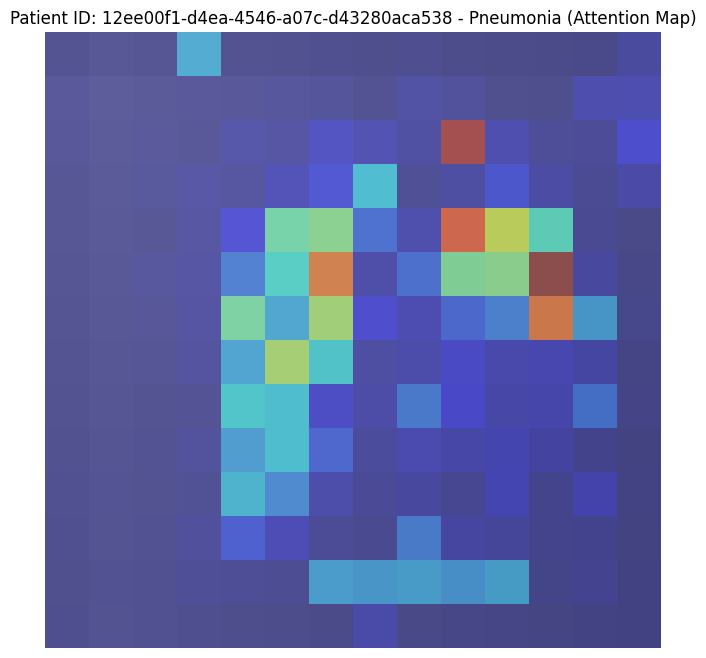

Processing Samples:  40%|████      | 2/5 [00:03<00:05,  1.68s/it]

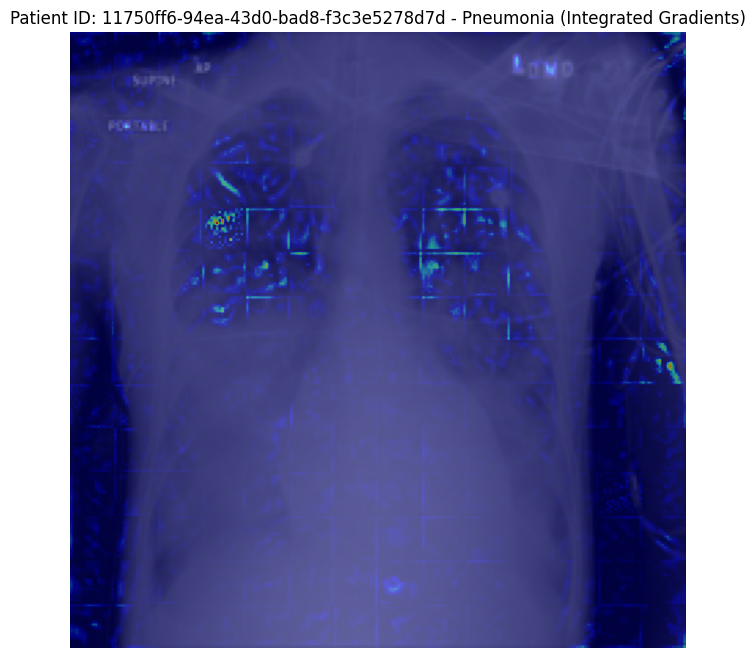

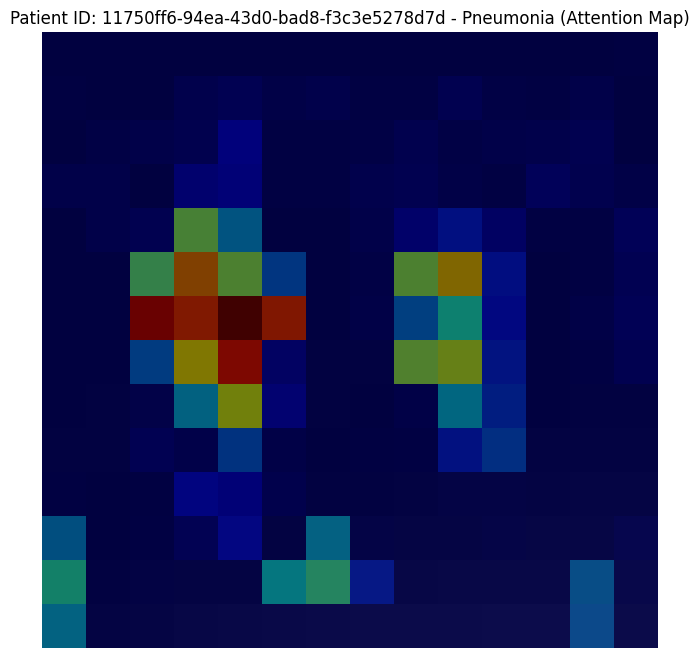

Processing Samples:  60%|██████    | 3/5 [00:04<00:03,  1.65s/it]

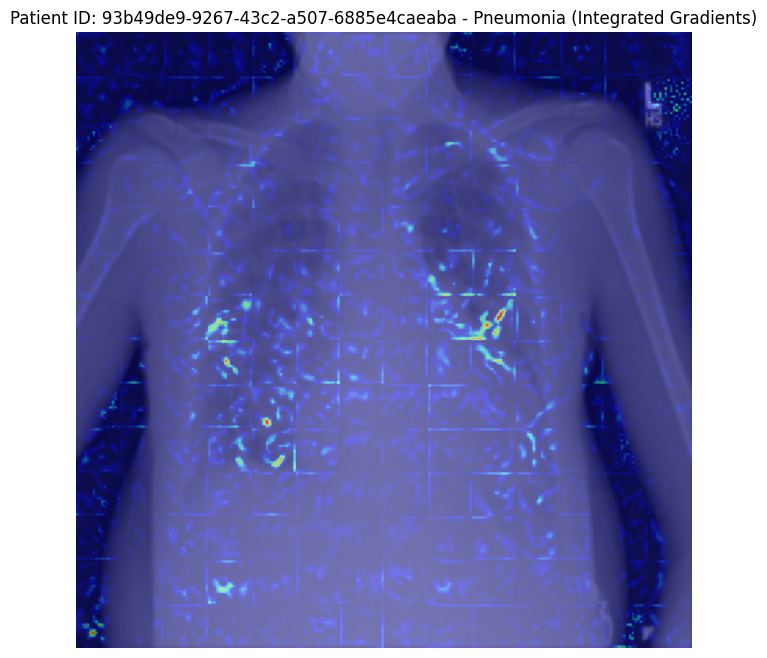

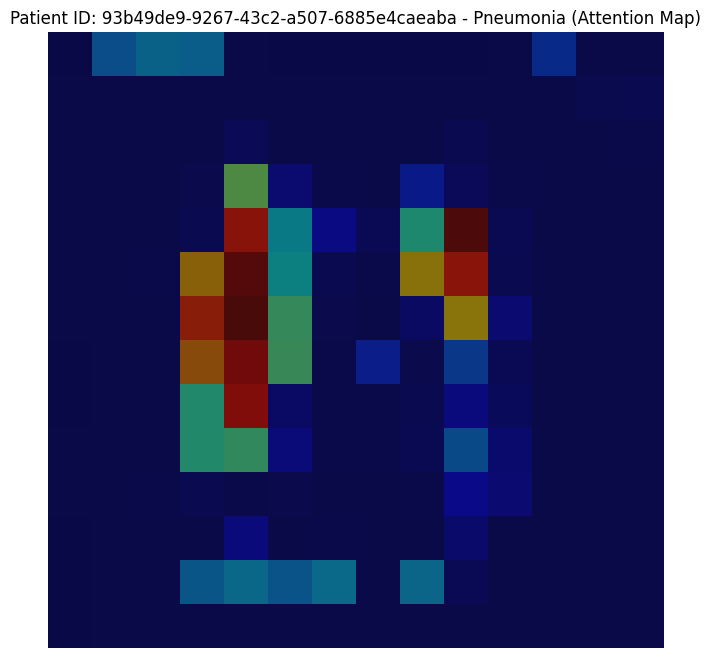

Processing Samples:  80%|████████  | 4/5 [00:06<00:01,  1.65s/it]

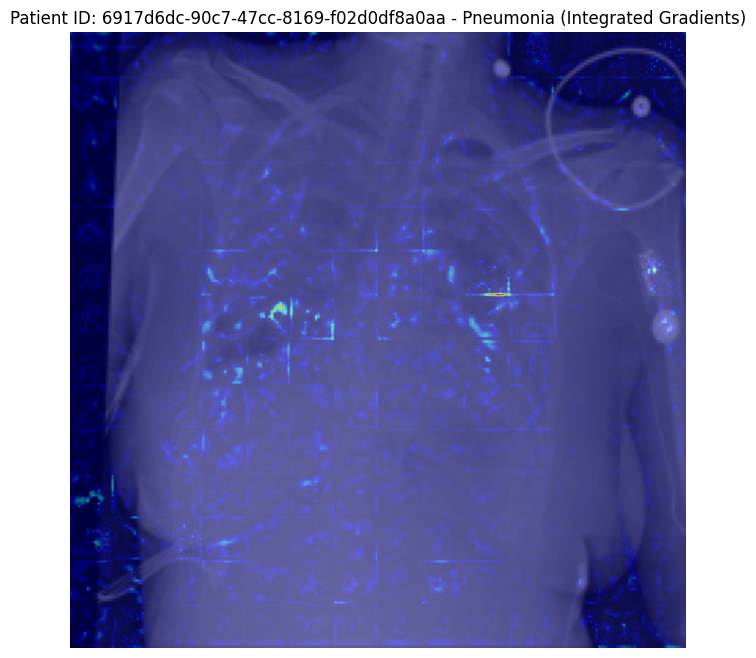

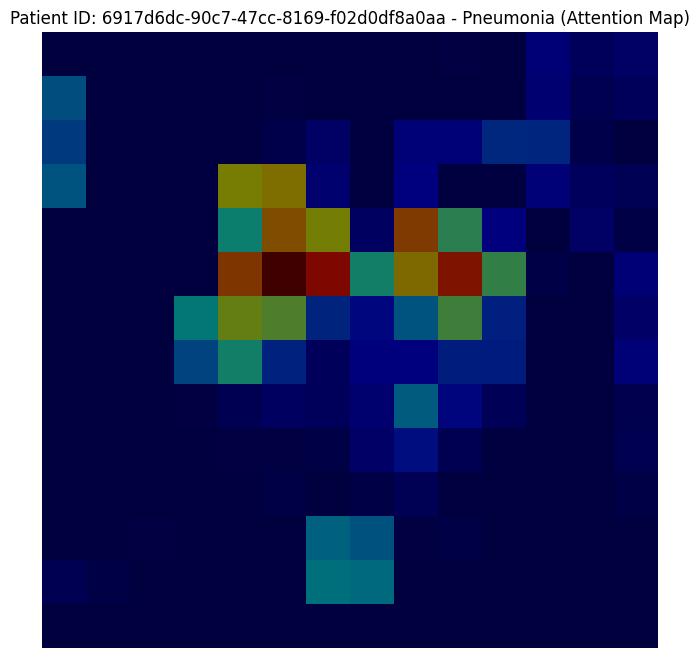

Processing Samples: 100%|██████████| 5/5 [00:08<00:00,  1.66s/it]

XAI visualizations completed and saved to /kaggle/working/


In [17]:
# ============================================================
# eXplainable AI (XAI) for Pneumonia Detection using ViT
# ============================================================

# -----------------------
# 1. Imports and Setup
# -----------------------

import os
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from transformers import ViTForImageClassification, ViTImageProcessor  # Updated import
from captum.attr import IntegratedGradients
import numpy as np
from tqdm import tqdm
import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# -----------------------
# 2. Dataset Definition
# -----------------------

# Define file paths (update these paths as per your environment)
images_dir = "/kaggle/input/rsna-pneumonia-processed-dataset/Training/Images"
masks_dir = "/kaggle/input/rsna-pneumonia-processed-dataset/Training/Masks"
train_metadata_path = "/kaggle/input/rsna-pneumonia-processed-dataset/stage2_train_metadata.csv"

# Load metadata
metadata = pd.read_csv(train_metadata_path)

# Filter metadata for specific classes
metadata = metadata[metadata['class'].isin(['Lung Opacity', 'Normal'])]
metadata['Target'] = metadata['class'].map({'Lung Opacity': 1, 'Normal': 0})

# Reset index after filtering
metadata = metadata.reset_index(drop=True)

# Define custom dataset class
class PneumoniaRSNADataset(Dataset):
    def __init__(self, metadata, images_dir, masks_dir, transform=None, mask_transform=None):
        self.metadata = metadata
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        patient_id = row['patientId']
        image_path = os.path.join(self.images_dir, f"{patient_id}.png")
        mask_path = os.path.join(self.masks_dir, f"{patient_id}.png")
        
        # Load image
        image = Image.open(image_path).convert("RGB")
        
        # Load mask if exists
        mask = Image.open(mask_path).convert("L") if os.path.exists(mask_path) else None

        label = row['Target']
        
        if self.transform:
            image = self.transform(image)
        if mask is not None and self.mask_transform:
            mask = self.mask_transform(mask)

        return image, label, mask

# Define transformations
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

mask_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Create dataset
train_dataset = PneumoniaRSNADataset(metadata, images_dir, masks_dir, transform=image_transform, mask_transform=mask_transform)

# -----------------------
# 3. Model Loading
# -----------------------

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model with attn_implementation="eager" to suppress warnings
model_path = "/kaggle/working/rsna_pneumonia_detection_vit"
model = ViTForImageClassification.from_pretrained(model_path, attn_implementation="eager")
model.eval()
model.to(device)

# Load image processor (updated from ViTFeatureExtractor)
image_processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")

# -----------------------
# 4. XAI with Integrated Gradients
# -----------------------

# Define a custom forward function that returns logits
def forward_func(inputs):
    """
    Forward function for the model that returns logits.

    Args:
        inputs (torch.Tensor): Input image tensor.

    Returns:
        torch.Tensor: Logits from the model.
    """
    outputs = model(inputs)
    return outputs.logits

# Initialize Integrated Gradients with the custom forward function
ig = IntegratedGradients(forward_func)

def generate_attributions(input_tensor, target_label, ig):
    """
    Generate Integrated Gradients attributions for a single input.

    Args:
        input_tensor (torch.Tensor): Input image tensor.
        target_label (int): The target class label.
        ig (IntegratedGradients): Initialized IntegratedGradients object.

    Returns:
        np.ndarray: Normalized attributions.
    """
    model.eval()
    input_tensor = input_tensor.to(device)

    # Compute attributions
    attributions, delta = ig.attribute(
        inputs=input_tensor, 
        target=target_label, 
        return_convergence_delta=True, 
        n_steps=50
    )

    # Process attributions
    attributions = attributions.squeeze(0).cpu().detach().numpy()
    attributions = np.sum(attributions, axis=0)  # Sum over channels
    attributions = np.maximum(attributions, 0)  # ReLU
    attributions = attributions / (attributions.max() + 1e-10)  # Normalize to avoid division by zero

    return attributions

def visualize_attributions(image_tensor, attributions, title="Attributions"):
    """
    Visualize attributions as a heatmap overlayed on the original image.

    Args:
        image_tensor (torch.Tensor): Original image tensor.
        attributions (np.ndarray): Attributions array.
        title (str): Title for the plot.
    """
    # Convert the tensor to a numpy array
    image = image_tensor.squeeze(0).cpu().detach().numpy()
    image = np.transpose(image, (1, 2, 0))  # C x H x W to H x W x C
    image = (image * 0.5) + 0.5  # Unnormalize

    # Normalize attributions
    attributions = (attributions - attributions.min()) / (attributions.max() - attributions.min() + 1e-10)

    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.imshow(attributions, cmap='jet', alpha=0.5)  # Overlay the heatmap
    plt.title(title)
    plt.axis('off')
    plt.show()

def visualize_and_save_attributions(image_tensor, attributions, title="Attributions", save_path=None):
    """
    Visualize and optionally save attributions.

    Args:
        image_tensor (torch.Tensor): Original image tensor.
        attributions (np.ndarray): Attributions array.
        title (str): Title for the plot.
        save_path (str, optional): Path to save the plot.
    """
    # Convert the tensor to a numpy array
    image = image_tensor.squeeze(0).cpu().detach().numpy()
    image = np.transpose(image, (1, 2, 0))  # C x H x W to H x W x C
    image = (image * 0.5) + 0.5  # Unnormalize

    # Normalize attributions
    attributions = (attributions - attributions.min()) / (attributions.max() - attributions.min() + 1e-10)

    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.imshow(attributions, cmap='jet', alpha=0.5)  # Overlay the heatmap
    plt.title(title)
    plt.axis('off')
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

# -----------------------
# 5. Attention Map Visualization
# -----------------------

def get_attention_map(model, input_tensor, layer_num=-1):
    """
    Extract and process the attention map from a specific layer of the ViT model.

    Args:
        model (ViTForImageClassification): Trained ViT model.
        input_tensor (torch.Tensor): Input image tensor.
        layer_num (int): Layer number to extract attention from (default: last layer).

    Returns:
        np.ndarray: Normalized attention map resized to image dimensions.
    """
    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor, output_attentions=True)
        # outputs.attentions is a tuple of (num_layers, batch_size, num_heads, seq_length, seq_length)
        attention = outputs.attentions[layer_num]  # Shape: (batch_size, num_heads, seq_length, seq_length)
        attention = attention.mean(dim=1).squeeze(0)  # Average over heads -> (seq_length, seq_length)
        attention_from_cls = attention[0, 1:]  # Attention from [CLS] token to each patch -> (196,)
        attention_map = attention_from_cls.reshape(14, 14).cpu().numpy()  # Reshape to [14,14]

        # Normalize
        attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min() + 1e-10)
    
    return attention_map

def visualize_attention(image_tensor, attention_map, title="Attention Map"):
    """
    Visualize the attention map overlayed on the original image.

    Args:
        image_tensor (torch.Tensor): Original image tensor.
        attention_map (np.ndarray): Attention map array.
        title (str): Title for the plot.
    """
    # Convert the tensor to a numpy array
    image = image_tensor.squeeze(0).cpu().detach().numpy()
    image = np.transpose(image, (1, 2, 0))  # C x H x W to H x W x C
    image = (image * 0.5) + 0.5  # Unnormalize

    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.imshow(attention_map, cmap='jet', alpha=0.5)  # Overlay the attention map
    plt.title(title)
    plt.axis('off')
    plt.show()

def visualize_and_save_attention(image_tensor, attention_map, title="Attention Map", save_path=None):
    """
    Visualize and optionally save the attention map.

    Args:
        image_tensor (torch.Tensor): Original image tensor.
        attention_map (np.ndarray): Attention map array.
        title (str): Title for the plot.
        save_path (str, optional): Path to save the plot.
    """
    # Convert the tensor to a numpy array
    image = image_tensor.squeeze(0).cpu().detach().numpy()
    image = np.transpose(image, (1, 2, 0))  # C x H x W to H x W x C
    image = (image * 0.5) + 0.5  # Unnormalize

    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.imshow(attention_map, cmap='jet', alpha=0.5)  # Overlay the attention map
    plt.title(title)
    plt.axis('off')
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    plt.show()

# -----------------------
# 6. Applying XAI and Visualization
# -----------------------

# Create a DataLoader for sample images (e.g., 5 pneumonia cases)
num_samples = 5
sample_indices = metadata[metadata['Target'] == 1].sample(n=num_samples, random_state=42).index.tolist()
sample_subset = Subset(train_dataset, sample_indices)
sample_loader = DataLoader(sample_subset, batch_size=1, shuffle=False)

# Iterate through the sample images and generate explanations
for idx, (image, label, mask) in enumerate(tqdm(sample_loader, desc="Processing Samples")):
    try:
        # Move tensors to device
        image = image.to(device)
        label = label.to(device)
        
        # Get patient ID for titles and saving
        patient_id = metadata.iloc[sample_indices[idx]]['patientId']
        label_str = 'Pneumonia' if label.item() == 1 else 'Normal'
        
        # -----------------------
        # Integrated Gradients Attribution
        # -----------------------
        
        try:
            # Generate attributions
            attributions = generate_attributions(image, target_label=label.item(), ig=ig)
            
            # Define title
            attribution_title = f"Patient ID: {patient_id} - {label_str} (Integrated Gradients)"
            
            # Define save path
            attribution_save_path = f"/kaggle/working/attribution_patient_{patient_id}.png"
            
            # Visualize and save attributions
            visualize_and_save_attributions(
                image,
                attributions,
                title=attribution_title,
                save_path=attribution_save_path
            )
        except Exception as e:
            print(f"Error generating attributions for patient {patient_id}: {e}")
        
        # -----------------------
        # Attention Map Visualization
        # -----------------------
        
        try:
            # Extract attention map from the last layer (layer_num=-1)
            attention_map = get_attention_map(model, image, layer_num=-1)
            
            # Define title
            attention_title = f"Patient ID: {patient_id} - {label_str} (Attention Map)"
            
            # Define save path
            attention_save_path = f"/kaggle/working/attention_patient_{patient_id}.png"
            
            # Visualize and save attention map
            visualize_and_save_attention(
                image,
                attention_map,
                title=attention_title,
                save_path=attention_save_path
            )
        except Exception as e:
            print(f"Error generating attention map for patient {patient_id}: {e}")
    
    except IndexError as ie:
        print(f"IndexError: {ie} - Skipping sample {idx}")
    except Exception as e:
        print(f"Unexpected error for sample {idx}: {e}")

print("XAI visualizations completed and saved to /kaggle/working/")
